# Image denoising in wavelet domain

### Author: Pawel Budzynski

In [1]:
import functools
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.signal


import nt_toolbox.general as nt_general
import nt_toolbox.signal as nt_signal

# Collection of filters taken from matlab implementation.
from wavelets.wavelets import get_wavelet_filter

In [2]:
# Define shortcut for plotting images with the same setting. 
imshow = functools.partial(plt.imshow, cmap='gray', interpolation='none')
# Load the image and transform it into one channel grayscale. 
image = skimage.io.imread('barbara.jpg')
image = skimage.color.rgb2gray(image)

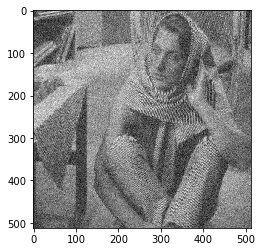

In [3]:
# Create a 2D white noise and add it to the image.
sigma = 0.1
noise = np.random.normal(scale=sigma, size=image.shape)
image_noise = image + noise

# Show the noised image.
imshow(image_noise)
plt.show()

In [4]:
def snr(
    x: np.ndarray, 
    y: np.ndarray,
) -> float:
    """Compute Signal to noise ratio given original signal 
    and signal with a noise added.
    
    Parameters:
        x: original signal. 
        y: noised signal.
    """
    return 10 * np.log10(np.sum(x**2) / np.sum((x - y)**2))

In [5]:
# Compute signal to noise ratio for the noised image.
print("SNR: ", snr(image, image_noise))

SNR:  13.513977364805738


## Thresholding in wavelet domain

Implementation of denoising in wavelet domain starts here. The functions were taken from Numerical tours toolset. First, to transform the image into wavelet domain the transformation parameters have to be defined. In the code below a filter $h$ is defined as an array of numbers, they are taken from the Numerical tours toolbox source code. The number of levels generated is another parameter and results for different values will be discussed later. 

In [6]:
# Define a filter and normalize it.
h = np.array([0, .482962913145, .836516303738, .224143868042, -.129409522551])
h = h/np.sqrt(np.sum(h**2))
# Define number of levels.
levels = 4

In [7]:
# Compute wavelet coefficients for the noised image.
a = nt_signal.perform_wavortho_transf(image_noise, levels, +1, h)

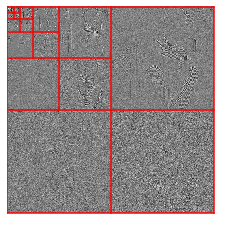

In [8]:
# Display the coefficients of noised image. 
_ = nt_signal.plot_wavelet(a, levels)

First, I am going to perform denoising using hard thresholding given as

\begin{equation}
s_{T}^{0}(\alpha)= 
\begin{cases}
    \alpha & \text{if } |\alpha| \gt T,\\
    0              & \text{otherwise,}
\end{cases}
\end{equation}
where
- $\alpha$ is a coefficient, 
- $T$ is a threshold value,
- $s_{T}^{0}$ is thresholding operator. 

In [9]:
def hard_threshold(
    arr: np.ndarray,
    t: float,
) -> np.ndarray:
    """Perform hard thresholding for the array of numbers."""
    aT = arr[:][:]
    aT[np.abs(aT) < t] = 0
    return aT

In [10]:
# Apply thresholding to the noised image coefficients.
aT = hard_threshold(a, 3*sigma)

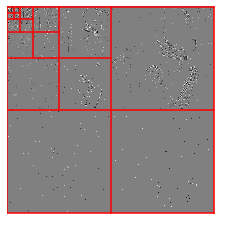

In [11]:
# Display the coefficients after thresholding.
_ = nt_signal.plot_wavelet(aT, levels)

In [12]:
# Perform inverse wavelet transform to recover the image from coefficients.
image_hard = nt_signal.perform_wavortho_transf(aT, levels, -1, h)

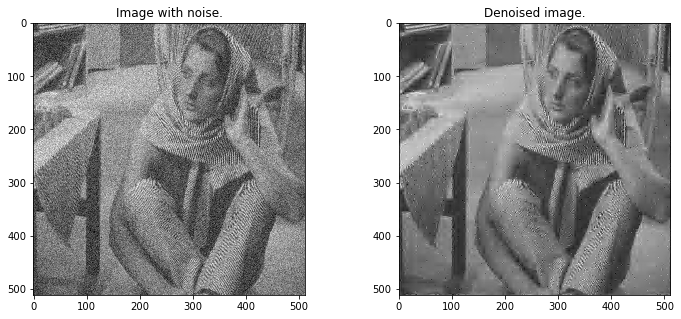

In [13]:
def compare_images(
    image_noised: np.ndarray,
    image_denoised: np.ndarray,
):
    _ = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    imshow(image_noised)
    plt.title('Image with noise.')

    plt.subplot(1, 2, 2)
    imshow(image_denoised)
    plt.title('Denoised image.')
    plt.show()
    
compare_images(image_noise, image_hard)

Having all the elements above I can collect them into a function that performs denoising for a given image. Later I will use it to test with different parameters like wavelet filters, number of levels and threshold values.

In [14]:
def normalize_vect(vect: np.ndarray) -> np.ndarray:
    """Normalize a vector."""
    return vect / np.sqrt(np.sum(vect ** 2))

def hard_threshold(
    arr: np.ndarray,
    threshold: float,
) -> np.ndarray:
    """Perform hard thresholding on an array of values."""
    aT = arr[:][:]
    aT[np.abs(aT) < threshold] = 0
    return aT

def soft_threshold(
    arr: np.ndarray,
    threshold: float,
) -> np.ndarray:
    """Perform soft thresholding on an array of values."""
    return np.maximum(0, 1-(threshold / np.abs(arr))) * arr

def climp(image: np.ndarray) -> np.ndarray:
    return np.minimum(np.maximum(image, 0.0), 1.0)

def denoise_with_wavelet(
    image_noised: np.ndarray,
    filter_: np.ndarray,
    n_levels: int,
    threshold: float,
    threshold_function: Callable,
    plot_wavelets: bool = False,
) -> np.ndarray:
    """Image denoising in wavelet domain. 
    Uses given parameters to transfer image into wavelet domain
    and denoise using given thresholding function.
    Returns denoised image. 
    
    Parameters:
        image_noised: Noised image to perform denoising on. 
        filter_: Array with filter parameters.
        n_levels: Number of levels for wavelet transform.
        threshold: Threshold walue to use in thresholding function. 
        threshold_function: Thresholding function to use.
        plot_wavelets: Optional to show wavelets coefficients 
                       before and after filtering.
                       
    Returns:
        image_reconstr: Denoised image.
    """
    
    filter_norm = normalize_vect(filter_)
    a = nt_signal.perform_wavortho_transf(
        image_noised, n_levels, +1, filter_norm)
    
    if plot_wavelets:
        _ = nt_signal.plot_wavelet(a, n_levels)
        
    aT = threshold_function(a, threshold)
    
    if plot_wavelets:
        _ = nt_signal.plot_wavelet(aT, n_levels)
        
    image_reconstr = nt_signal.perform_wavortho_transf(
        aT, n_levels, -1, filter_norm)
    
    return climp(image_reconstr)

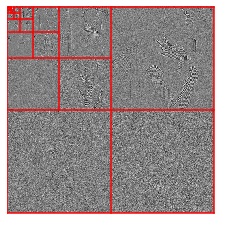

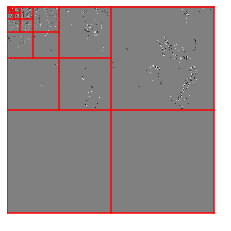

In [15]:
# Possible filters: Daubechies, Coiflet, Symmlet
filter_ = get_wavelet_filter('Symmlet', 4)

image_rec = denoise_with_wavelet(
    image_noise, 
    filter_=filter_,
    n_levels=2,
    threshold=4*sigma,
    threshold_function=hard_threshold,
    plot_wavelets=True,
)

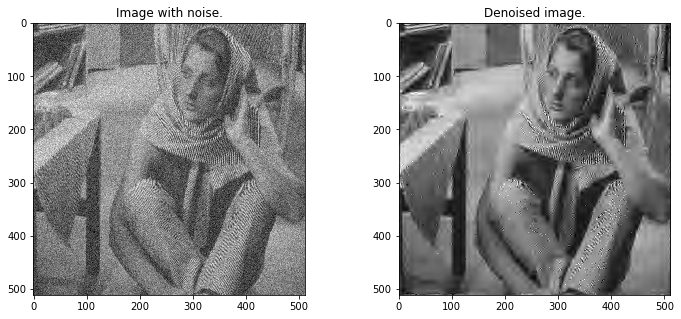

In [16]:
compare_images(image_noise, image_rec)

### Denoising for various SNR levels

SNR:  -0.01563388823204182


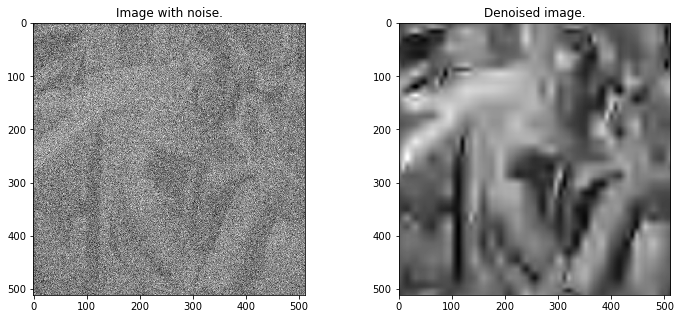

SNR:  9.989954498022444


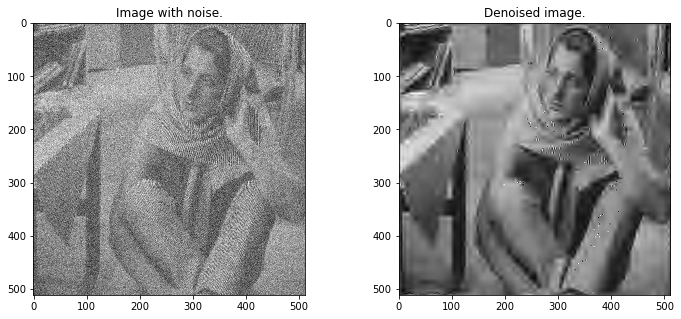

SNR:  19.98389241085638


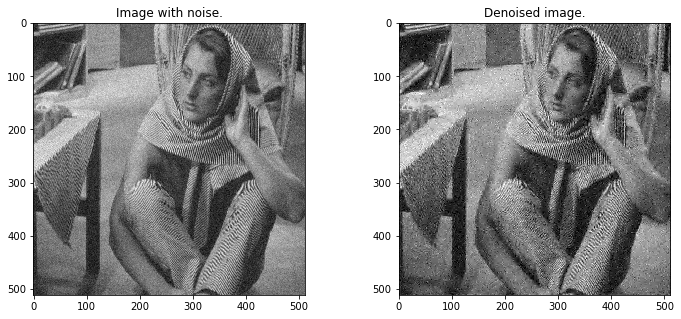

In [17]:
def snr_to_n_std(
    snr: float, 
    signal: np.ndarray,
) -> float:
    """Compute noise variance for requested SNR."""
    N = np.size(signal)
    return np.sqrt(np.sum(signal**2) / (10**(snr / 10) * N))

for SNR in (0, 10, 20):
    # Compute Std to generate noised image with desired SNR.
    noise_std = snr_to_n_std(SNR, image)
    # Generate noised version of the image.
    noised_image = image + np.random.normal(scale=noise_std, size=image.shape)
    # Denoise image using thresholding in wavelet domain.
    denoised_image = denoise_with_wavelet(
        image_noise, 
        filter_=filter_,
        n_levels=4,
        threshold=4*noise_std,
        threshold_function=hard_threshold,
        plot_wavelets=False,
    )
    print("SNR: ", snr(image, noised_image))
    compare_images(noised_image, denoised_image)

As it was easy to guess the results are better in case of higher SNR values since the original signal strengh is greater than noise. When signal and noise have comparable strenght (SNR 0db) the results are very poor as the filter is unable to distinguish between image and noise information.

## Parameters discussion. 
Below results of denoising with different sets of parameters are presented.

### Hard thresholding vs Soft thresholding

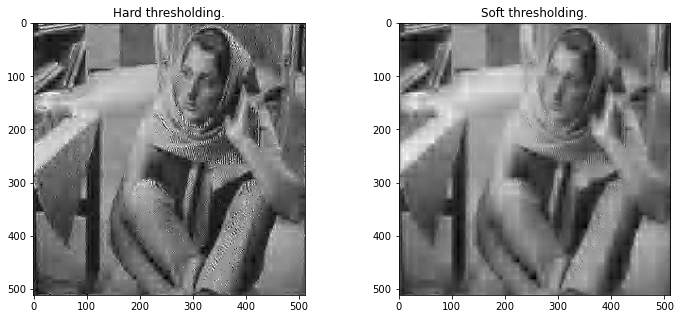

In [18]:
filter_ = get_wavelet_filter("Daubechies", 4)
sigma = 0.1

# Denoise with hard thresholding.
image_rec_hard = denoise_with_wavelet(
    image_noise, 
    filter_=filter_,
    n_levels=4,
    threshold=4*sigma,
    threshold_function=hard_threshold,
    plot_wavelets=False,
)
# Denoise with soft thresholding.
image_rec_soft = denoise_with_wavelet(
    image_noise, 
    filter_=filter_,
    n_levels=2,
    threshold=4*sigma,
    threshold_function=soft_threshold,
    plot_wavelets=False,
)

_ = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
imshow(image_rec_hard)
plt.title("Hard thresholding.")
plt.subplot(1, 2, 2)
imshow(image_rec_soft)
plt.title("Soft thresholding.")
plt.show()

The results of soft transform in this case seem to be very blurred however the contrast is visibly higher.

### Number of levels

Hard thresholding.


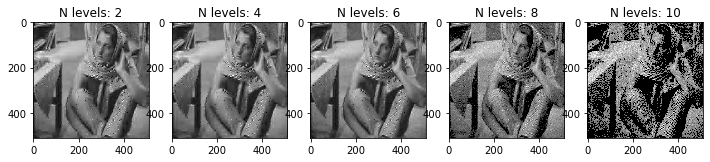

Soft thresholding.


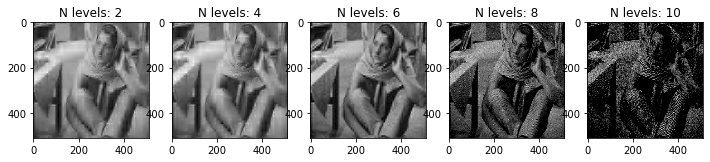

In [19]:
filter_ = get_wavelet_filter("Daubechies", 4)
sigma = 0.1

print("Hard thresholding.")
_ = plt.figure(figsize=(12, 5))
for i, levels in enumerate(range(2, 11, 2)):
    # Denoise with hard thresholding.
    image_rec_hard = denoise_with_wavelet(
        image_noise, 
        filter_=filter_,
        n_levels=levels,
        threshold=4*sigma,
        threshold_function=hard_threshold,
        plot_wavelets=False,
    )
    
    plt.subplot(1, 5, i+1)
    imshow(image_rec_hard)
    plt.title(f"N levels: {levels}")
plt.show()


print("Soft thresholding.")
_ = plt.figure(figsize=(12, 5))
for i, levels in enumerate(range(2, 11, 2)):
    # Denoise with soft thresholding.
    image_rec_soft = denoise_with_wavelet(
        image_noise, 
        filter_=filter_,
        n_levels=levels,
        threshold=4*sigma,
        threshold_function=soft_threshold,
        plot_wavelets=False,
    )
    
    plt.subplot(1, 5, i+1)
    imshow(image_rec_soft)
    plt.title(f"N levels: {levels}")
plt.show()

In both cases the quality of denoised images seem to be better when a number of levels is bigger however when the number is too high the image starts to look much worse (N levels=10). Thus number of levels for denoising should be chosen wisely. 

### Wavelets types

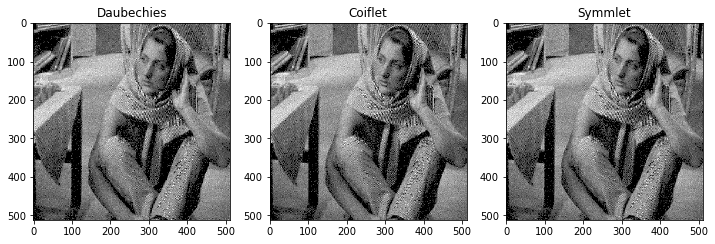

In [20]:
# Possible filters: Daubechies, Coiflet, Symmlet
i = 1
fig = plt.figure(figsize=(12, 5))

for filter_name, param in (("Daubechies", 4), ("Coiflet", 2), ("Symmlet", 4)):
    filter_ = get_wavelet_filter(filter_name, param)
    plt.subplot(1, 3, i)
    image_rec = denoise_with_wavelet(
        image_noise, 
        filter_=filter_,
        n_levels=8,
        threshold=4*sigma,
        threshold_function=hard_threshold,
        plot_wavelets=False,
    )
    imshow(image_rec)
    plt.title(filter_name)
    i += 1
    
plt.show()

There is not much wisible difference between outputs of denoising for various filters used.

### Daubechies filter number of parameters

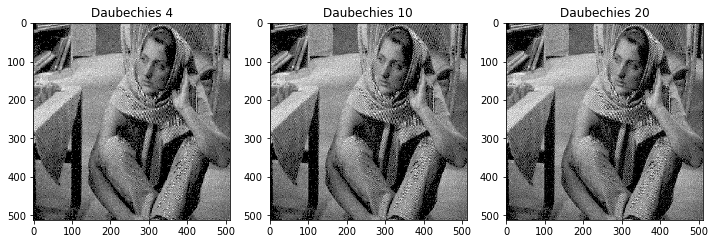

In [21]:
# Possible filters: Daubechies, Coiflet, Symmlet
i = 1
fig = plt.figure(figsize=(12, 5))

for param in (4, 10, 20):
    filter_ = get_wavelet_filter("Daubechies", param)
    plt.subplot(1, 3, i)
    image_rec = denoise_with_wavelet(
        image_noise, 
        filter_=filter_,
        n_levels=8,
        threshold=4*sigma,
        threshold_function=hard_threshold,
        plot_wavelets=False,
    )
    imshow(image_rec)
    plt.title(f"Daubechies {param}")
    i += 1
    
plt.show()

Similarly number of parameters of Daubechies filter seem to have little impact on the denoising.

## Translation invariant wavelet transform

Since orthogonal wavelet transformation is not translation invariant below implementation is to use cycle spinning to generate a number of shifted images that will be denoised and the result is an average of the denoised shifted copies. The implementation below was created following Numerical Tours tutorial. 


In [22]:
def denoise_with_wavelet_invariant(
    image_noise: np.ndarray,
    m: int,
    levels: int,
    filter_: np.ndarray,
    threshold: float,
    threshold_function: Callable,
):
    [dY,dX] = np.meshgrid(np.arange(0,m), np.arange(0,m))
    delta = np.concatenate( 
        (dX.reshape(m*m,1), dY.reshape(m*m,1)),
        axis=1,
    )
    fTI = np.zeros(image_noise.shape)
    for i in range(0, m*m):
        # Perform a circle shift of an image.
        fS = nt_general.circshift(image_noise, delta[i,:])
        # Wavelet transform.
        a = nt_signal.perform_wavortho_transf(fS, levels, 1, filter_)
        # Thresholding.
        aT = threshold_function(a, threshold)
        # Inverse Wavelet transform.
        fS = nt_signal.perform_wavortho_transf(aT, levels, -1, filter_)
        # Perform a circle shift of a reconstructed image.
        fS = nt_general.circshift(fS, -delta[i,:])
        # Accumulate partial results into the final image.
        fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS
        
    return np.minimum(np.maximum(fTI, 0.0), 1.0)

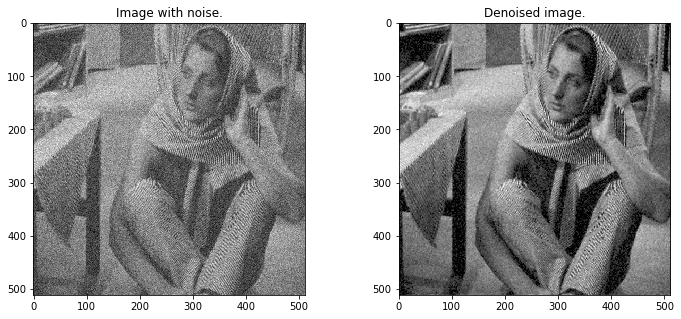

In [23]:
image_denoised = denoise_with_wavelet_invariant(
    image_noise,
    m=2,
    levels=8,
    filter_=get_wavelet_filter('Daubechies', 4),
    threshold=3*sigma,
    threshold_function=hard_threshold,
)

compare_images(image_noise, image_denoised)

## Conclusions
- Denoising using thresholding in wavelet domain was implemented with a help of numerical toolbox taken from Numerical Tours.
- Such a type of denoising gives pretty good result if the parameters are well tuned. In addition, it is an useful tool since denoising does not require any information about the noise. 
- Wavelet transforms are not translation invariant.
- Translation invariant version of the denoising can be implemented although it is more computationaly expensive since it requires to generate shifted image and performing denoising for each single one.